In [3]:
import xarray as xr
import sys
import matplotlib.pyplot as plt
## Import the ecco_v4_py library into Python
## =========================================
from os.path import expanduser,join
import sys
user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import numpy as np
import cartopy.crs as crs
import cartopy.feature as cfeature

In [4]:
## Set top-level file directory for the ECCO NetCDF files
## change ECCO_dir as needed
ECCO_dir = join(user_home_dir,'ECCOv4-py','ECCO_V4r4_PODAAC')
ECCO_dir
# grid parameter file name and path (after it has been downloaded)
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
grid_params_file = "GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc"
grid_params_file_path = join(ECCO_dir,grid_params_shortname,grid_params_file)
# open grid parameters file
grid = xr.open_dataset(grid_params_file_path)

<Figure size 1000x400 with 0 Axes>

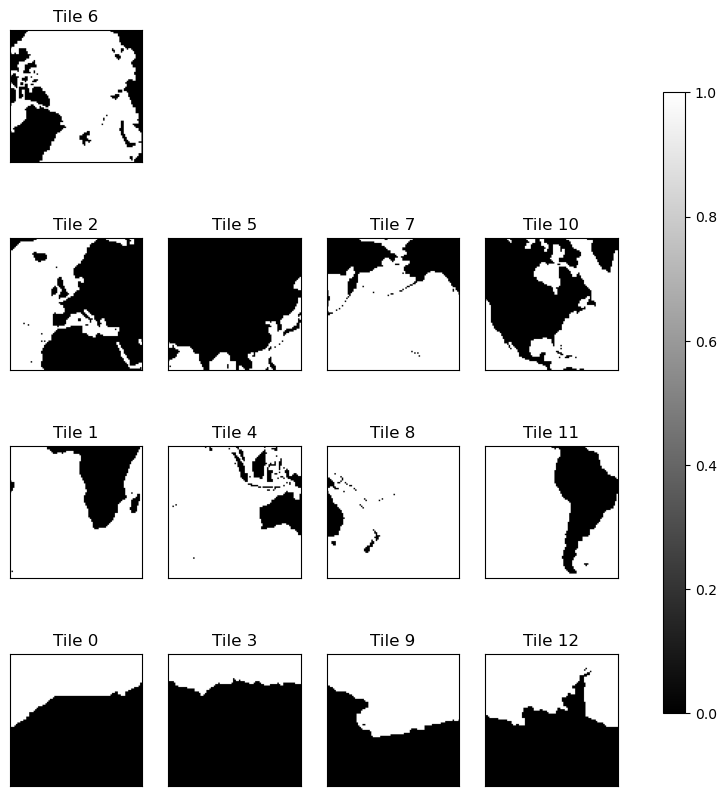

In [33]:
# surface mask
plt.figure(figsize=[10,4])
ecco.plot_tiles(grid.hFacC.isel(k=1), cmap='gray',layout='latlon',
                show_colorbar=True,rotate_to_latlon=True);

# Mask for 2D surface area over entire tile

In [ ]:
# load the ecco grid into memory
grid.load();

In [27]:
# Select the surface index
depthINDEX = 0  # Represents the surface

# Pull tile 11 from the land mask
mask = grid.maskC.isel(k=depthINDEX, tile=11).copy(deep=True)

# Multiply the grid cell area with the land mask
area_mask = grid.rA.isel(tile=11) * mask.compute()

# Calculate the total area of wet cells in tile 11
total_area_mask = area_mask.sum(dim=['i', 'j']).compute()

# The mask is defined by a(i,j)/total_area_mask
# Each grid cell is weighted by its fraction of the total area
area_mask_coef = area_mask / total_area_mask

# Create a new DataArray object, using grid.XC as the template for coordinates, etc.
global_2D_mask = grid.XC.copy(deep=True) * 0
# Populate the values in tile 11 with the area-weighted mask values calculated above
global_2D_mask.isel(tile=11).values[:] = area_mask_coef[:]
# Give it a helpful name
global_2D_mask.name = 'custom_2D_mask'
global_2D_mask.attrs['long_name'] = 'Custom area-weighted 2D mask of wet cells in tile 11'

# Verify that the global sum of the mask is 1
print(f'Global sum of area-weighted mask values is {global_2D_mask.sum().values}')

#global_2D_mask

Global sum of area-weighted mask values is 1.0


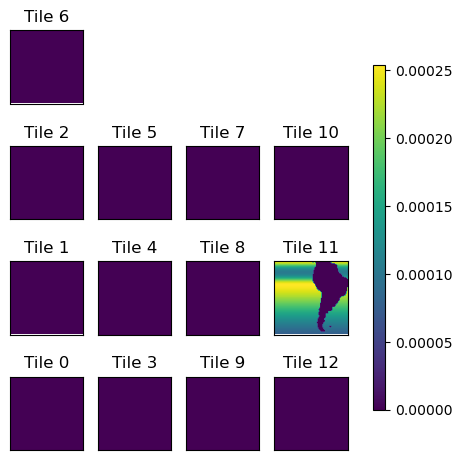

In [20]:
ecco.plot_tiles(global_2D_mask, layout='latlon', 
                rotate_to_latlon=True, fig_size=5, 
                show_colorbar=True);

##  Save mask in binary (Big Endian Byte Order) and netcdf 

In [26]:
global_2D_mask_compact = ecco.llc_tiles_to_compact(global_2D_mask)

llc_tiles_to_faces: num_tiles,  13
llc_faces_to_compact: face 3 shape (90, 90)
llc_faces_to_compact: data_compact array shape (1170, 90)
llc_faces_to_compact: data_compact array dtype float32


In [25]:
name_mask='global_2D_mask_by_entire_tile'
# for binary 
from pathlib import Path
file_path_compact = Path(name_mask+'.bin')
with open(file_path_compact, "wb") as file:
    global_2D_mask_compact.astype('>f4').tofile(file)
# for netcdf
file_path_netcdf = Path(name_mask+'.nc')
with open(file_path_netcdf, "wb") as file:
    global_2D_mask.to_netcdf(file)

In [ ]:
# read the mask in netcdf format
test_nc = xr.open_dataset(file_path_netcdf)
print(test_nc.data_vars)
ecco.plot_tiles(test_nc.custom_2D_mask,layout='latlon', 
                rotate_to_latlon=True, fig_size=5, 
                show_colorbar=True);

plt.figure(figsize=[10,5])
ecco.plot_proj_to_latlon_grid(test_nc.XC, test_nc.YC,
                                  test_nc.custom_2D_mask,dx=1,dy=1, 
                                  show_colorbar=True,show_grid_labels=True);